In [294]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [295]:
data= pd.read_csv("cleaned_data_csv.csv")

In [296]:
data.head()

,Continent,Location,Date,Total_Cases,New_Cases,New cases smoothed,Total_deaths,New_deaths,new deaths smoothed,total cases per million,...,median age,aged 65 older,aged 70 older,extreme poverty,cardiovasc death rate,diabetes prevalence,female smokers,male smokers,hospital beds per thousand,life expectancy
0,Asia,Afghanistan,2020-02-24,5,5,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
1,Asia,Afghanistan,2020-02-25,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
2,Asia,Afghanistan,2020-02-26,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
3,Asia,Afghanistan,2020-02-27,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
4,Asia,Afghanistan,2020-02-28,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83


In [297]:
# create a new column 'new_cases_lag7' with a lag of 7 days
data['new_cases_lag7'] = data['New_Cases'].shift(7)

# print the first 10 rows of the dataframe
data

,Continent,Location,Date,Total_Cases,New_Cases,New cases smoothed,Total_deaths,New_deaths,new deaths smoothed,total cases per million,...,aged 65 older,aged 70 older,extreme poverty,cardiovasc death rate,diabetes prevalence,female smokers,male smokers,hospital beds per thousand,life expectancy,new_cases_lag7
0,Asia,Afghanistan,2020-02-24,5,5,0.000,1,0,0.000,0.126,...,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83,NaN
1,Asia,Afghanistan,2020-02-25,5,0,0.000,1,0,0.000,0.126,...,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83,NaN
2,Asia,Afghanistan,2020-02-26,5,0,0.000,1,0,0.000,0.126,...,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83,NaN
3,Asia,Afghanistan,2020-02-27,5,0,0.000,1,0,0.000,0.126,...,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83,NaN
4,Asia,Afghanistan,2020-02-28,5,0,0.000,1,0,0.000,0.126,...,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166321,Africa,Zimbabwe,2022-03-01,236871,491,413.000,5395,0,1.000,15694.959,...,2.822,1.882,21.4,307.846,1.82,1.6,30.7,1,61.49,409.0
166322,Africa,Zimbabwe,2022-03-02,237503,632,416.286,5396,1,1.143,15736.835,...,2.822,1.882,21.4,307.846,1.82,1.6,30.7,1,61.49,609.0
166323,Africa,Zimbabwe,2022-03-03,237503,0,362.286,5396,0,0.857,15736.835,...,2.822,1.882,21.4,307.846,1.82,1.6,30.7,1,61.49,378.0
166324,Africa,Zimbabwe,2022-03-04,238739,1236,467.429,5397,1,0.714,15818.731,...,2.822,1.882,21.4,307.846,1.82,1.6,30.7,1,61.49,500.0


In [298]:
def create_df(data, continent):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Continent']==continent].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()

    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [299]:
data2_asia=create_df(data, 'Asia')

In [300]:
data2_asia.head()

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
0,2020-02-24,5,5,1,0,0.0,0.0,0.126
1,2020-02-25,5,0,1,0,0.0,0.0,0.000
2,2020-02-26,5,0,1,0,0.0,0.0,0.000
3,2020-02-27,5,0,1,0,0.0,0.0,0.000
4,2020-02-28,5,0,1,0,0.0,0.0,0.000


In [301]:
data2_asia=data2_asia.loc[:,['Date','New_Cases']]
data2_asia=data2_asia.set_index('Date')

In [302]:
data2_asia

,New_Cases
Date,
2020-02-24,5
2020-02-25,0
2020-02-26,0
2020-02-27,0
2020-02-28,0
...,...
2022-03-01,0
2022-03-02,0
2022-03-03,1


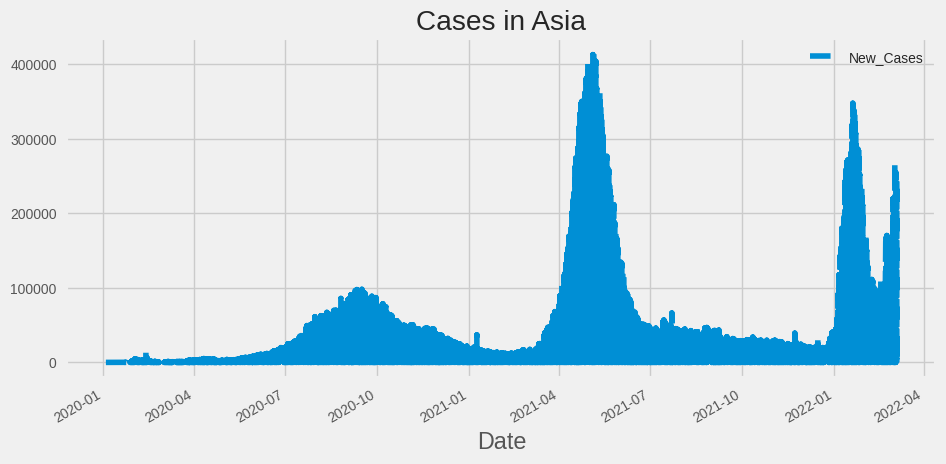

In [303]:
color_pal = sns.color_palette()
data2_asia.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in Asia')
plt.show()

Text(0, 0.5, 'New cases')

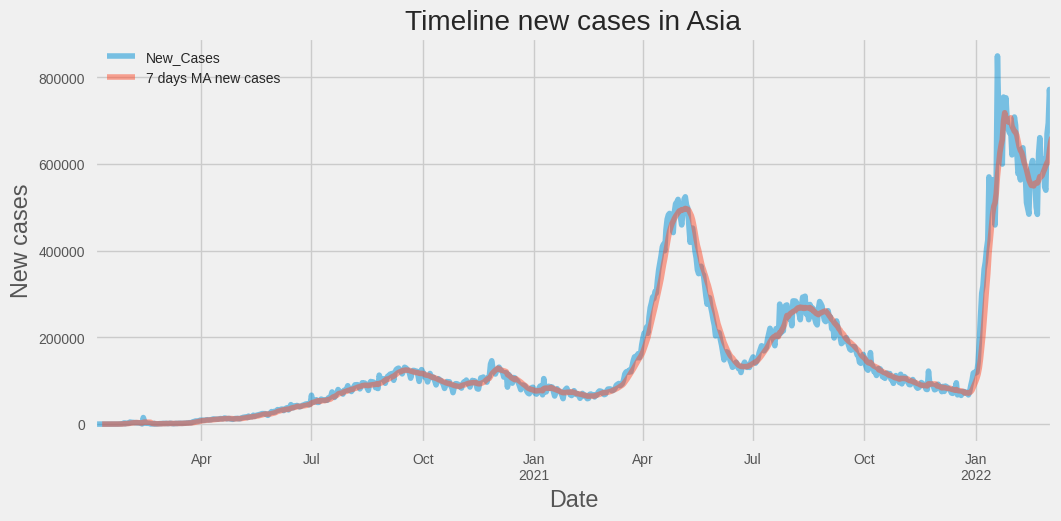

In [304]:
data2 = data2_asia.copy()
data2 = data2_asia.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data2 = data2.groupby('Date').sum()
data2['7 days MA new cases'] = 0
data2['7 days MA new cases'] = data2['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data2[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in Asia')
plt.xlabel('Date')
plt.ylabel('New cases')

In [305]:
data2 = data2.dropna(subset=['7 days MA new cases'])

In [306]:
data2 = data2.drop('New_Cases', axis=1)

In [307]:
data2.head()

,7 days MA new cases
Date,
2020-01-10,0.0
2020-01-11,0.0
2020-01-12,0.0
2020-01-13,0.0
2020-01-14,0.0


In [308]:
data2_africa=create_df(data, 'Africa')

In [309]:
data2_africa.head()

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
741,2020-02-13,1,0,1,0,0.0,0.0,0.000
742,2020-02-14,1,1,1,0,0.0,0.0,0.001
743,2020-02-15,1,0,1,0,0.0,0.0,0.000
744,2020-02-16,1,0,1,0,0.0,0.0,0.000
745,2020-02-17,1,0,1,0,0.0,0.0,0.000


In [310]:
data2_africa=data2_africa.loc[:,['Date','New_Cases']]
data2_africa=data2_africa.set_index('Date')

In [311]:
data2_africa

,New_Cases
Date,
2020-02-13,0
2020-02-14,1
2020-02-15,0
2020-02-16,0
2020-02-17,0
...,...
2022-03-01,491
2022-03-02,632
2022-03-03,0


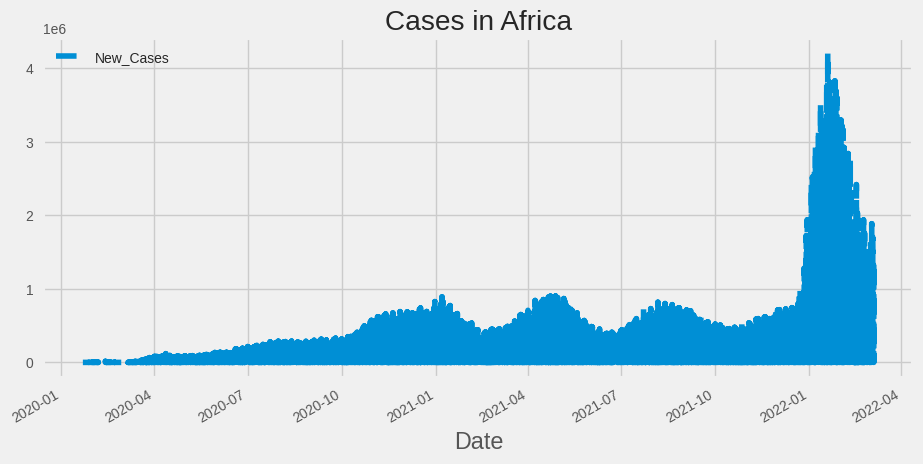

In [312]:
color_pal = sns.color_palette()
data2_africa.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in Africa')
plt.show()

Text(0, 0.5, 'New cases')

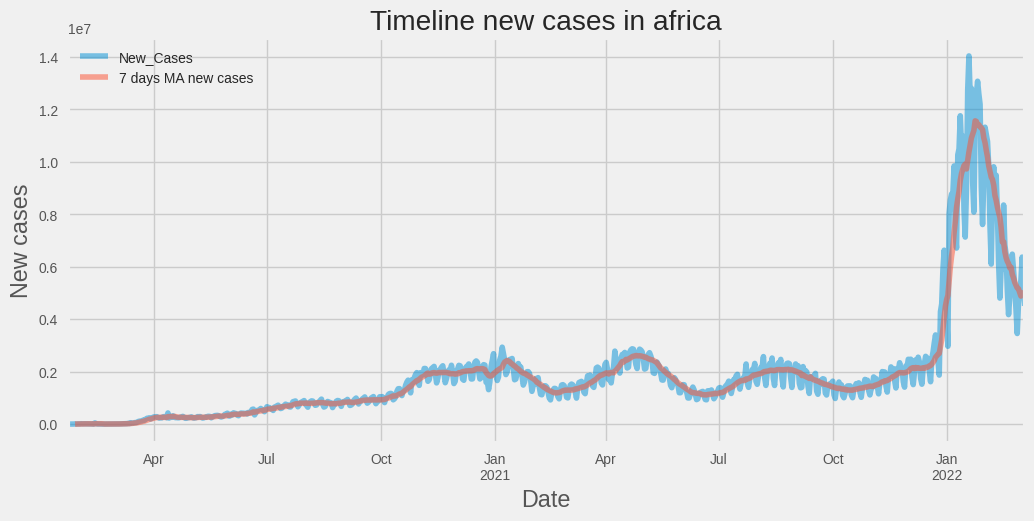

In [313]:
data3 = data2_africa.copy()
data3 = data2_africa.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data3 = data3.groupby('Date').sum()
data3['7 days MA new cases'] = 0
data3['7 days MA new cases'] = data3['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data3[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in africa')
plt.xlabel('Date')
plt.ylabel('New cases')

In [314]:
data3= data3.dropna(subset=['7 days MA new cases'])

In [315]:
data3 = data3.drop('New_Cases', axis=1)

In [316]:
data3.head()

,7 days MA new cases
Date,
2020-01-28,2153.857143
2020-01-29,2406.571429
2020-01-30,3250.000000
2020-01-31,3851.428571
2020-02-01,4545.571429


In [317]:
data2_europe=create_df(data, 'Europe')

In [318]:
data2_europe

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
1493,2020-02-25,1,0,1,0,0.0,0.0,0.0
1494,2020-02-26,1,0,1,0,0.0,0.0,0.0
1495,2020-02-27,1,0,1,0,0.0,0.0,0.0
1496,2020-02-28,1,0,1,0,0.0,0.0,0.0
1497,2020-02-29,1,0,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
161420,2022-03-01,29,0,1,0,0.0,0.0,0.0
161421,2022-03-02,29,0,1,0,0.0,0.0,0.0
161422,2022-03-03,29,0,1,0,0.0,0.0,0.0
161423,2022-03-04,29,0,1,0,0.0,0.0,0.0


In [319]:
data2_europe=data2_europe.loc[:,['Date','New_Cases']]
data2_europe=data2_europe.set_index('Date')

In [320]:
data2_europe

,New_Cases
Date,
2020-02-25,0
2020-02-26,0
2020-02-27,0
2020-02-28,0
2020-02-29,0
...,...
2022-03-01,0
2022-03-02,0
2022-03-03,0


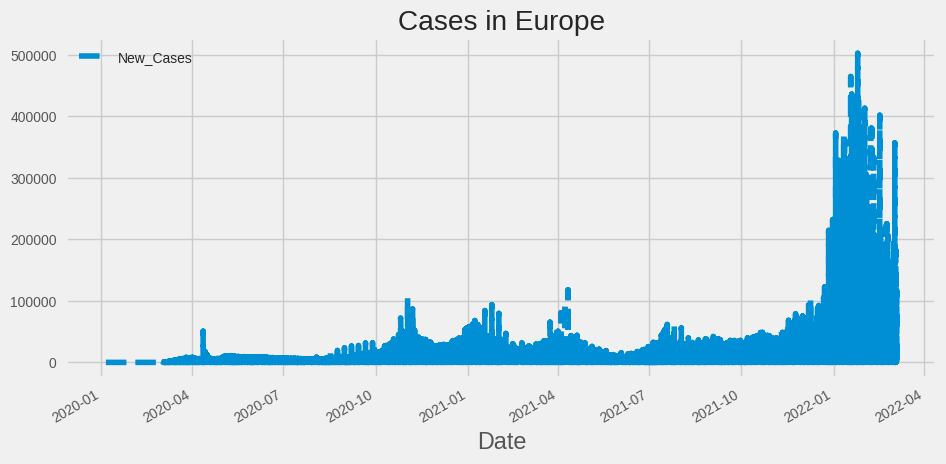

In [321]:
color_pal = sns.color_palette()
data2_europe.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in Europe')
plt.show()

Text(0, 0.5, 'New cases')

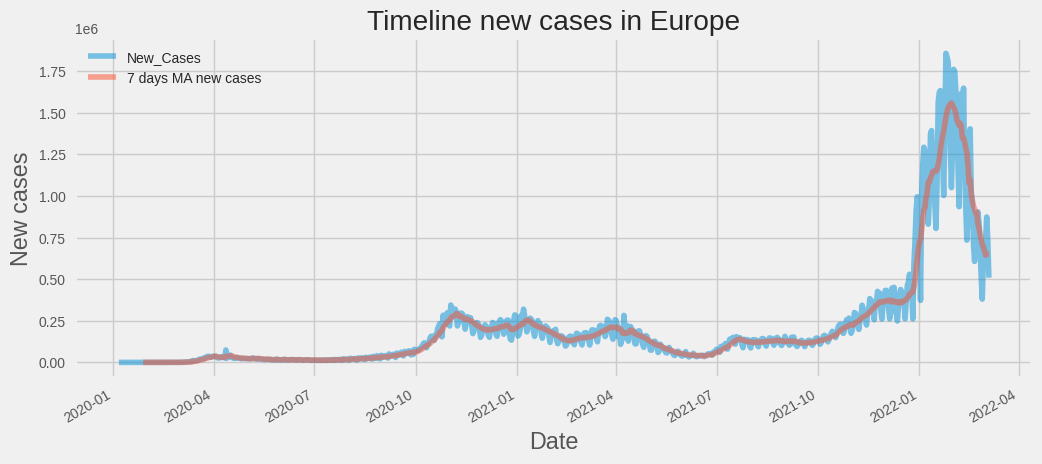

In [322]:
data4 = data2_europe.copy()
data4 = data2_europe.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data4 = data4.groupby('Date').sum()
data4['7 days MA new cases'] = 0
data4['7 days MA new cases'] = data4['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data4[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in Europe')
plt.xlabel('Date')
plt.ylabel('New cases')

In [323]:
data4 = data4.dropna(subset=['7 days MA new cases'])

In [324]:
data4 = data4.drop('New_Cases', axis=1)

In [325]:
data4.head()

,7 days MA new cases
Date,
2020-01-28,1.142857
2020-01-29,1.428571
2020-01-30,1.428571
2020-01-31,2.142857
2020-02-01,2.857143


In [326]:
data2_northamerica=create_df(data, "North America")

In [327]:
data2_northamerica

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
4423,2020-03-28,2,2,1,0,0.00,0.00,132.231
4424,2020-03-29,2,0,1,0,0.00,0.00,0.000
4425,2020-03-30,2,0,1,0,0.00,0.00,0.000
4426,2020-03-31,2,0,1,0,0.00,0.00,0.000
4427,2020-04-01,2,0,1,0,0.00,0.00,0.000
...,...,...,...,...,...,...,...,...
157991,2022-03-01,79091361,47031,952423,1691,76.47,64.81,141.270
157992,2022-03-02,79143716,52355,954518,2095,76.49,64.83,157.262
157993,2022-03-03,79196008,52292,956261,1743,76.50,64.84,157.073
157994,2022-03-04,79250509,54501,958144,1883,76.50,64.84,163.708


In [328]:
data2_northamerica=data2_northamerica.loc[:,['Date','New_Cases']]
data2_northamerica=data2_northamerica.set_index('Date')

In [329]:
data2_northamerica

,New_Cases
Date,
2020-03-28,2
2020-03-29,0
2020-03-30,0
2020-03-31,0
2020-04-01,0
...,...
2022-03-01,47031
2022-03-02,52355
2022-03-03,52292


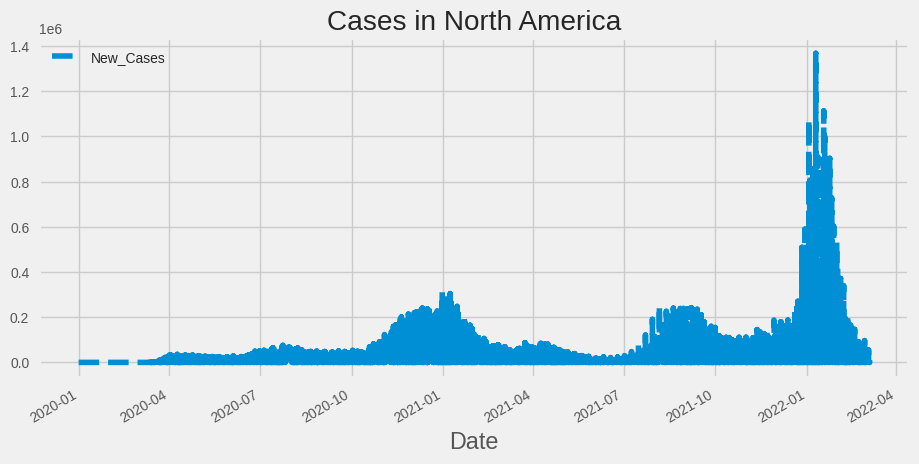

In [330]:
color_pal = sns.color_palette()
data2_northamerica.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in North America')
plt.show()

Text(0, 0.5, 'New cases')

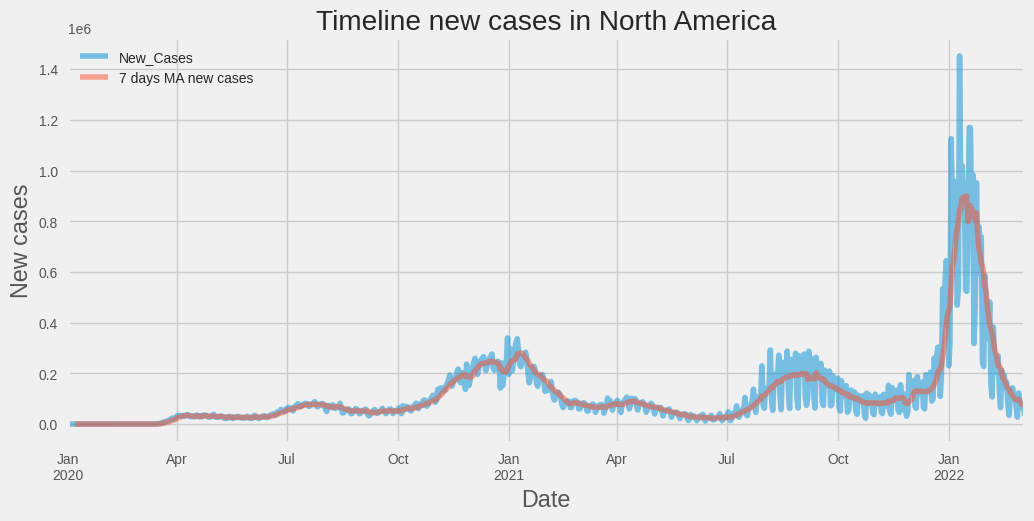

In [331]:
data5 = data2_northamerica.copy()
data5 = data2_northamerica.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data5 = data5.groupby('Date').sum()
data5['7 days MA new cases'] = 0
data5['7 days MA new cases'] = data5['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data5[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in North America')
plt.xlabel('Date')
plt.ylabel('New cases')

In [332]:
data5 = data5.dropna(subset=['7 days MA new cases'])

In [333]:
data5 = data5.drop('New_Cases', axis=1)

In [334]:
data5.head()

,7 days MA new cases
Date,
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,0.0
2020-01-10,0.0
2020-01-11,0.0


In [335]:
data2_oceania=create_df(data, 'Oceania')

In [336]:
data2_oceania

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
8908,2020-01-26,4,4,1,0,0.0,0.0,0.155
8909,2020-01-27,5,1,1,0,0.0,0.0,0.039
8910,2020-01-28,5,0,1,0,0.0,0.0,0.000
8911,2020-01-29,6,1,1,0,0.0,0.0,0.039
8912,2020-01-30,9,3,1,0,0.0,0.0,0.116
...,...,...,...,...,...,...,...,...
163418,2022-03-01,454,0,7,0,0.0,0.0,0.000
163419,2022-03-02,454,0,7,0,0.0,0.0,0.000
163420,2022-03-03,454,0,7,0,0.0,0.0,0.000
163421,2022-03-04,454,0,7,0,0.0,0.0,0.000


In [337]:
data2_oceania=data2_oceania.loc[:,['Date','New_Cases']]
data2_oceania=data2_oceania.set_index('Date')

In [338]:
data2_oceania

,New_Cases
Date,
2020-01-26,4
2020-01-27,1
2020-01-28,0
2020-01-29,1
2020-01-30,3
...,...
2022-03-01,0
2022-03-02,0
2022-03-03,0


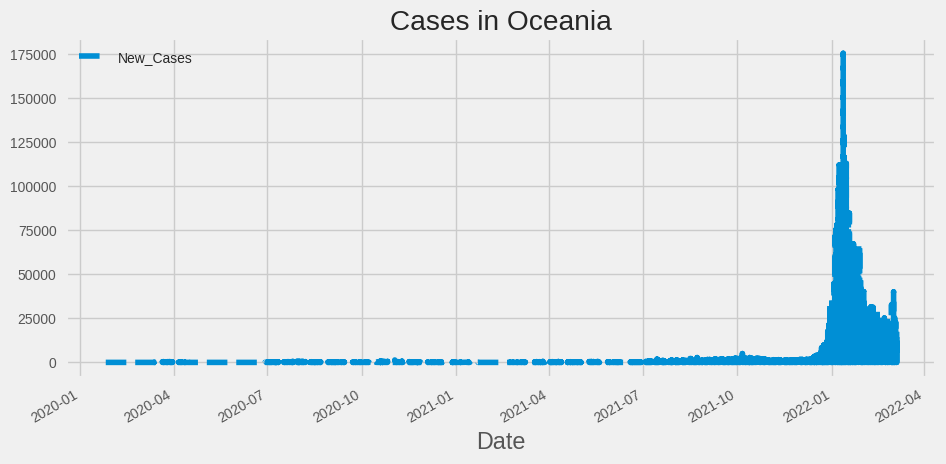

In [339]:
color_pal = sns.color_palette()
data2_oceania.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in Oceania')
plt.show()

Text(0, 0.5, 'New cases')

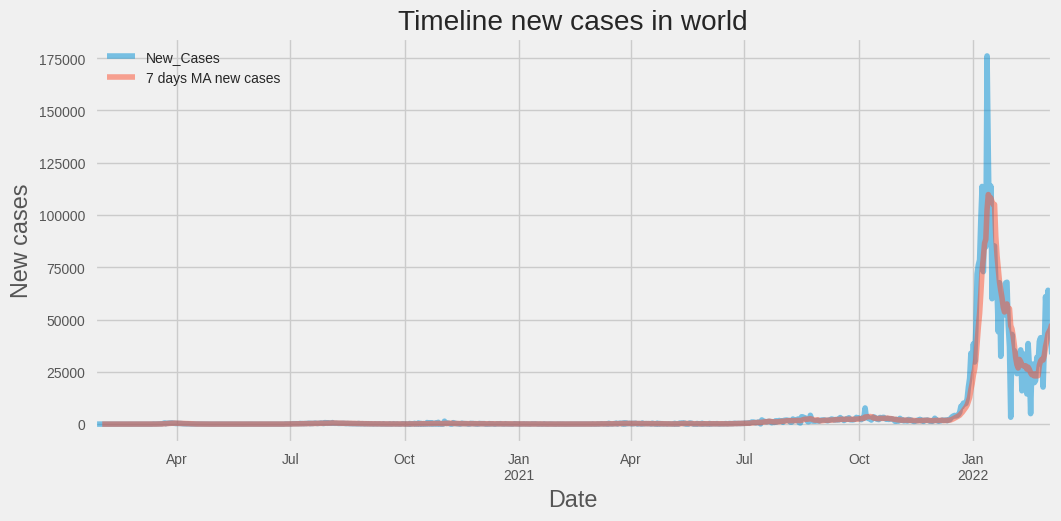

In [340]:
data6 = data2_oceania.copy()
data6 = data2_oceania.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data6 = data6.groupby('Date').sum()
data6['7 days MA new cases'] = 0
data6['7 days MA new cases'] = data6['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data6[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in world')
plt.xlabel('Date')
plt.ylabel('New cases')

In [341]:
data6 = data6.dropna(subset=['7 days MA new cases'])

In [342]:
data6 = data6.drop('New_Cases', axis=1)

In [343]:
data6.head()

,7 days MA new cases
Date,
2020-02-01,1.714286
2020-02-02,1.142857
2020-02-03,1.000000
2020-02-04,1.142857
2020-02-05,1.000000


In [344]:
data2_southamerica=create_df(data, "South America")

In [345]:
data2_southamerica

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
5854,2020-01-01,1,0,1,0,0.0,0.0,0.000
5855,2020-01-02,1,0,1,0,0.0,0.0,0.000
5856,2020-01-03,1,0,1,0,0.0,0.0,0.000
5857,2020-01-04,1,0,1,0,0.0,0.0,0.000
5858,2020-01-05,1,0,1,0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...
162142,2022-03-01,515124,0,5636,0,0.0,0.0,0.000
162143,2022-03-02,515582,458,5639,3,0.0,0.0,15.955
162144,2022-03-03,515943,361,5643,4,0.0,0.0,12.576
162145,2022-03-04,516236,293,5645,2,0.0,0.0,10.207


In [346]:
data2_southamerica=data2_southamerica.loc[:,['Date','New_Cases']]
data2_southamerica=data2_southamerica.set_index('Date')

In [347]:
data2_southamerica

,New_Cases
Date,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2022-03-01,0
2022-03-02,458
2022-03-03,361


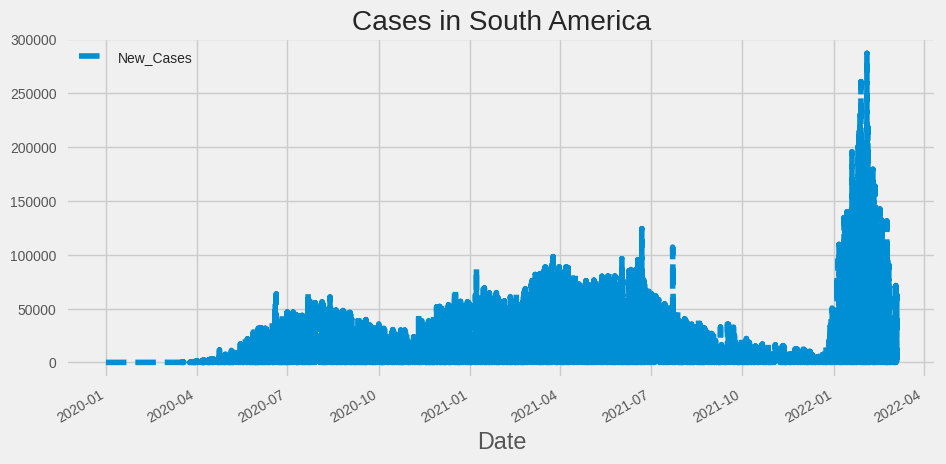

In [348]:
color_pal = sns.color_palette()
data2_southamerica.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases in South America')
plt.show()

Text(0, 0.5, 'New cases')

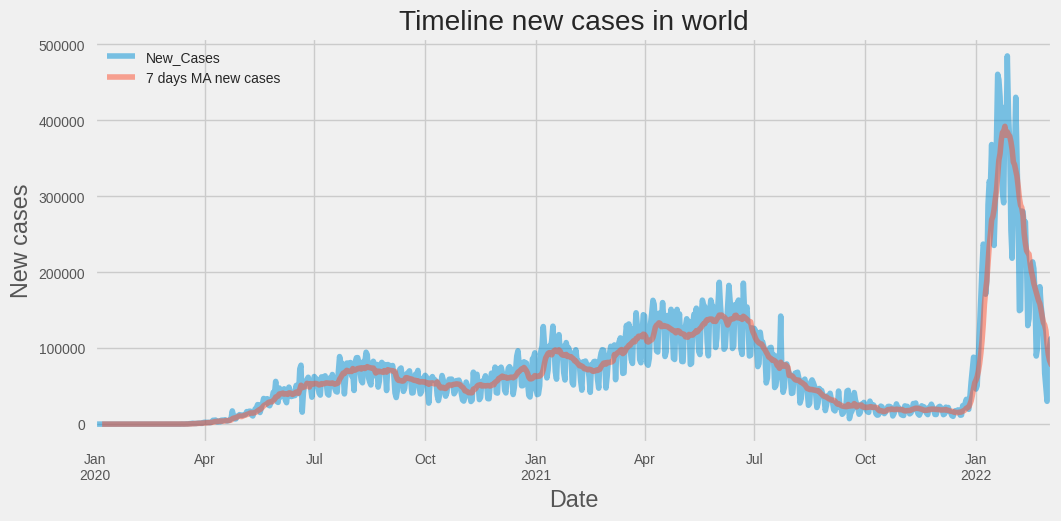

In [349]:
data7 = data2_southamerica.copy()
data7 = data2_southamerica.copy()
#data2.date = pd.to_datetime(data2_india['Date'])
data7 = data7.groupby('Date').sum()
data7['7 days MA new cases'] = 0
data7['7 days MA new cases'] = data7['New_Cases'].rolling(7).mean() #Moving average of new cases with window=10
data7[['New_Cases', '7 days MA new cases']].plot(figsize = (11, 5), alpha = 0.5)
plt.title('Timeline new cases in world')
plt.xlabel('Date')
plt.ylabel('New cases')

In [350]:
data7 = data7.dropna(subset=['7 days MA new cases'])

In [351]:
data7 = data7.drop('New_Cases', axis=1)

In [352]:
data7.head()

,7 days MA new cases
Date,
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,0.0
2020-01-10,0.0
2020-01-11,0.0


In [353]:
from pandas.api.types import CategoricalDtype

cat_type= CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

def  create_features(df, label=None):
  df=df.copy()
  df['Date']=df.index
  df['hour']=df['Date'].dt.hour
  df['dayofweek']=df['Date'].dt.dayofweek
  df['weekday']=df['Date'].dt.day_name()
  df['weekday']=df['weekday'].astype(cat_type)
  df['quarter']=df['Date'].dt.quarter
  df['month']=df['Date'].dt.month
  df['year']=df['Date'].dt.year
  df['dayofyear']=df['Date'].dt.dayofyear
  df['dayofmonth']=df['Date'].dt.day
  df['weekofyear']=df['Date'].dt.weekofyear
  df['date_offset']=(df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

  df['season']=pd.cut(df['date_offset'], [0,300, 602, 900,1300],
                      labels=['Spring','Summer','Fall','Winter']
                      )
  X=df[['hour','dayofweek','quarter','month','year','dayofyear',
        'dayofmonth','weekofyear','weekday',
        'season']]
  if label:
    y=df[label]
    return X,y
  return X

X,y = create_features(data2,label='7 days MA new cases')
features_and_target = pd.concat([X,y],axis=1)         


In [354]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,7 days MA new cases
Date,,,,,,,,,,,
2020-01-10,0,4,1,1,2020,10,10,2,Friday,Winter,0.0
2020-01-11,0,5,1,1,2020,11,11,2,Saturday,Winter,0.0
2020-01-12,0,6,1,1,2020,12,12,2,Sunday,Winter,0.0
2020-01-13,0,0,1,1,2020,13,13,3,Monday,Winter,0.0
2020-01-14,0,1,1,1,2020,14,14,3,Tuesday,Winter,0.0


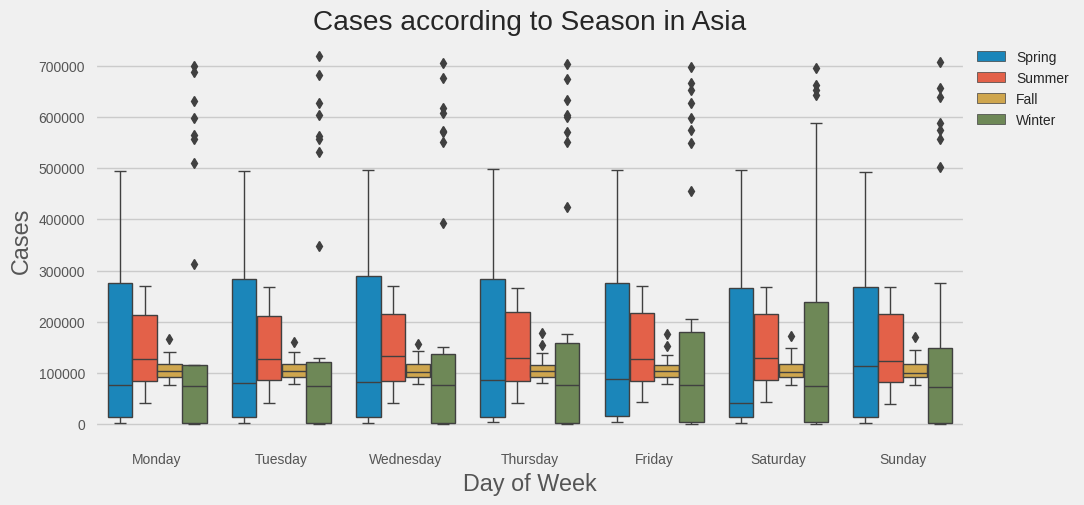

In [355]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='7 days MA new cases',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Cases according to Season in Asia')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Cases')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

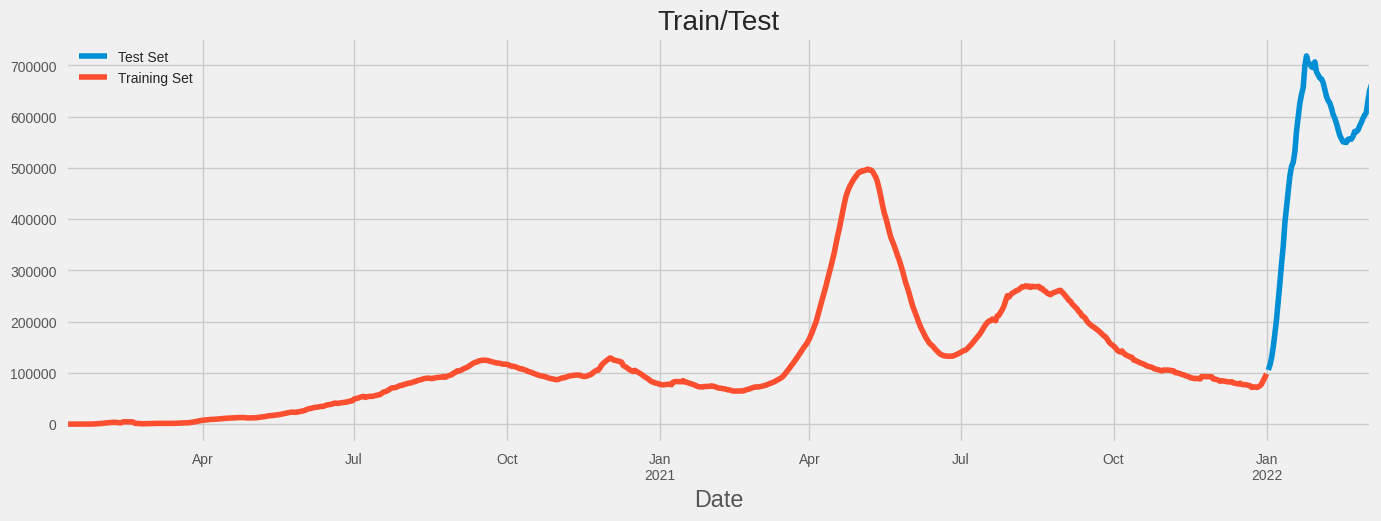

In [356]:
 split_date='01-jan-2022'

 date_train_asia = data2.loc[data2.index <=split_date].copy()
 date_test_asia = data2.loc[data2.index >split_date].copy()

 date_test_asia \
        .rename(columns={'7 days MA new cases': 'Test Set'}) \
        .join(date_train_asia.rename(columns={'7 days MA new cases': 'Training Set'}),
              how='outer') \
        .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [357]:
#Holt Winter Model

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

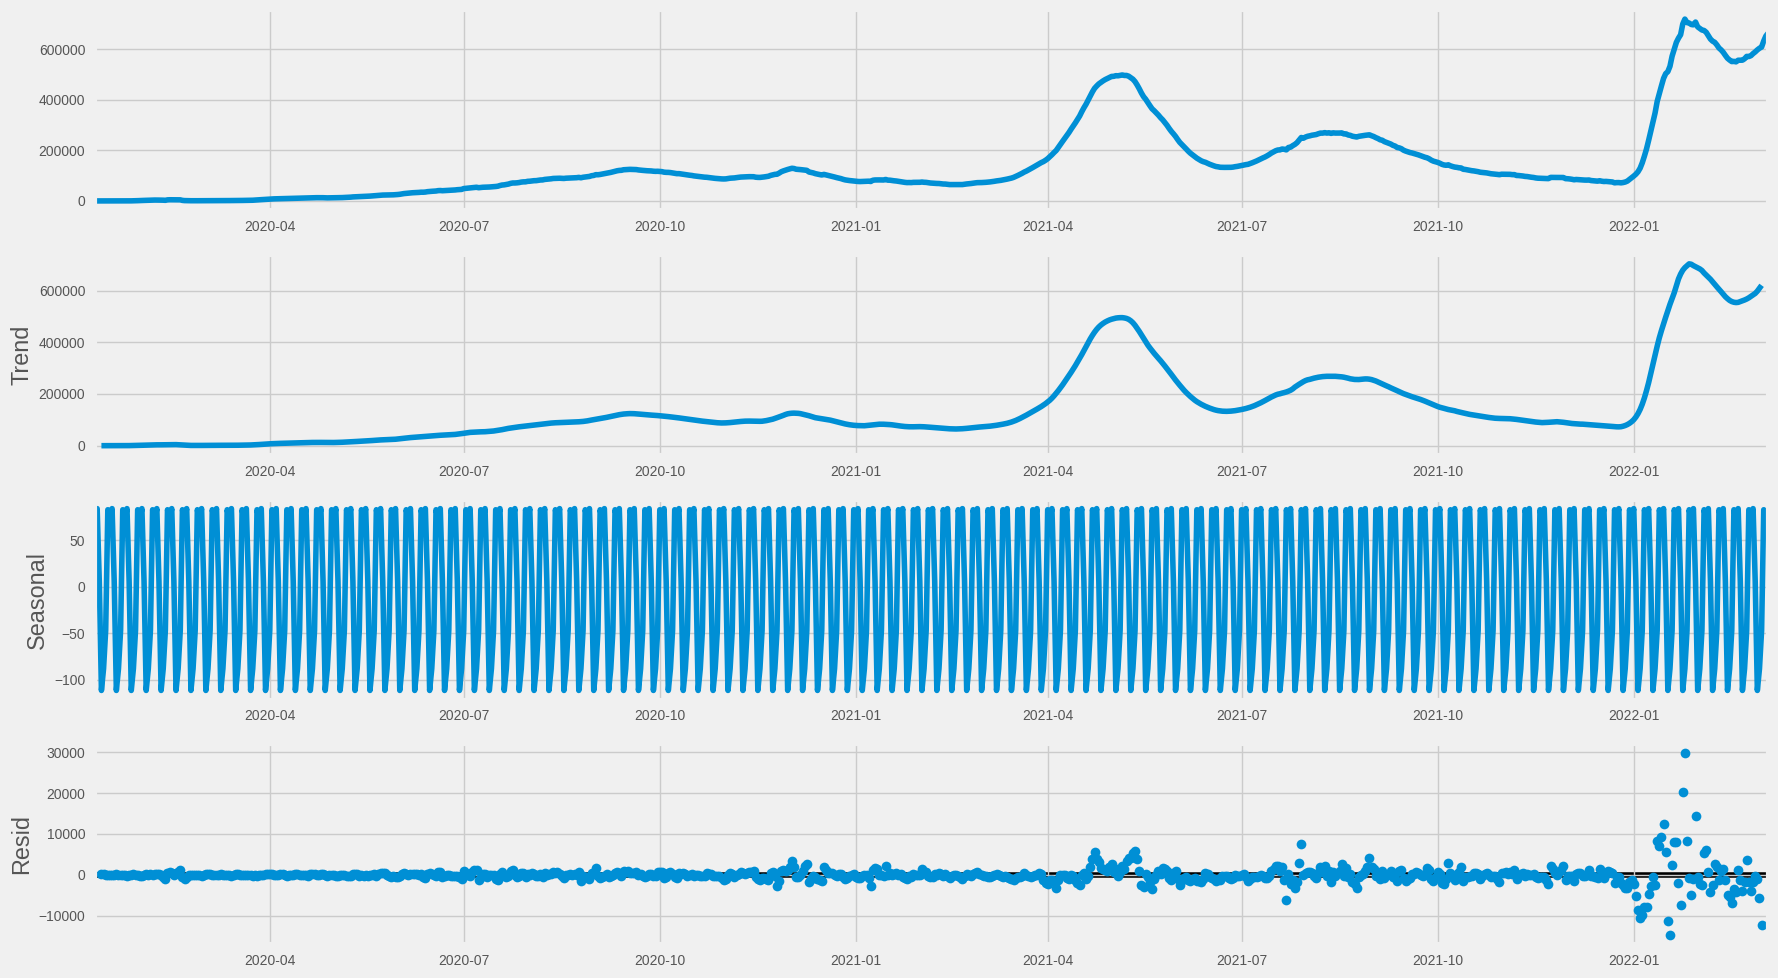

In [358]:
seasonal_decompose(data2,model='additive').plot();

In [359]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [360]:
hwmodel=ExponentialSmoothing(date_train_asia,trend='add', seasonal='add', seasonal_periods=4).fit()

In [361]:
test_pred=hwmodel.forecast(63)

In [362]:
test_pred

2022-01-02    104966.151532
2022-01-03    111788.892609
2022-01-04    118608.432024
2022-01-05    125457.521962
2022-01-06    132288.241631
                  ...      
2022-03-01    501117.693414
2022-03-02    507966.783352
2022-03-03    514797.503021
2022-03-04    521620.244098
2022-03-05    528439.783513
Freq: D, Length: 63, dtype: float64

<Axes: xlabel='Date'>

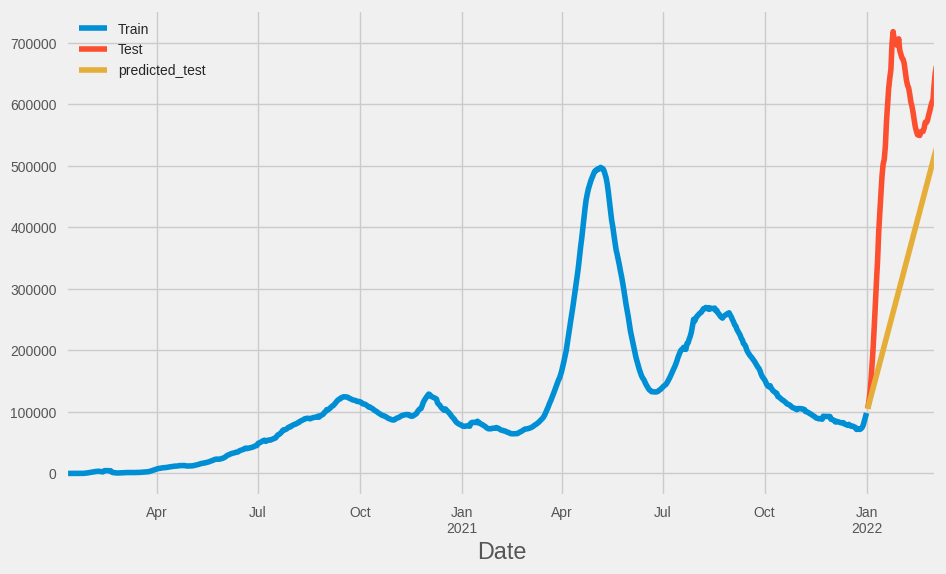

In [363]:
date_train_asia['7 days MA new cases'].plot(legend=True, label='Train', figsize=(10,6))
date_test_asia['7 days MA new cases'].plot(legend=True, label='Test')

test_pred.plot(legend=True, label='predicted_test')

In [364]:
from sklearn.metrics import mean_squared_error

In [365]:
np.sqrt(mean_squared_error(date_test_asia,test_pred))

257421.68274840922

In [366]:
#Obtaining the holt linear predictions object using the training data
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller


holt = Holt(np.asarray(date_train_asia['7 days MA new cases'])).fit(smoothing_level = 0.4, smoothing_slope = 0.4, optimized = False)     

In [367]:
#Obtaining the predictions of the holt linear model using test data

y_pred=date_test_asia.copy()

model_scores = []
y_pred["Holt"] = holt.forecast(len(date_test_asia))
model_scores.append(np.sqrt(mean_squared_error(y_pred['7 days MA new cases'], y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ", np.sqrt(mean_squared_error(y_pred['7 days MA new cases'], y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  302286.9100585383


In [368]:
data2.mean(), np.sqrt(data2.var())

(7 days MA new cases    149976.335333
 dtype: float64,
 7 days MA new cases    159702.408931
 dtype: float64)

In [369]:
final_model=ExponentialSmoothing(data2,trend='add', seasonal='add', seasonal_periods=4).fit()

In [370]:
pred=final_model.forecast(360)

<Axes: xlabel='Date'>

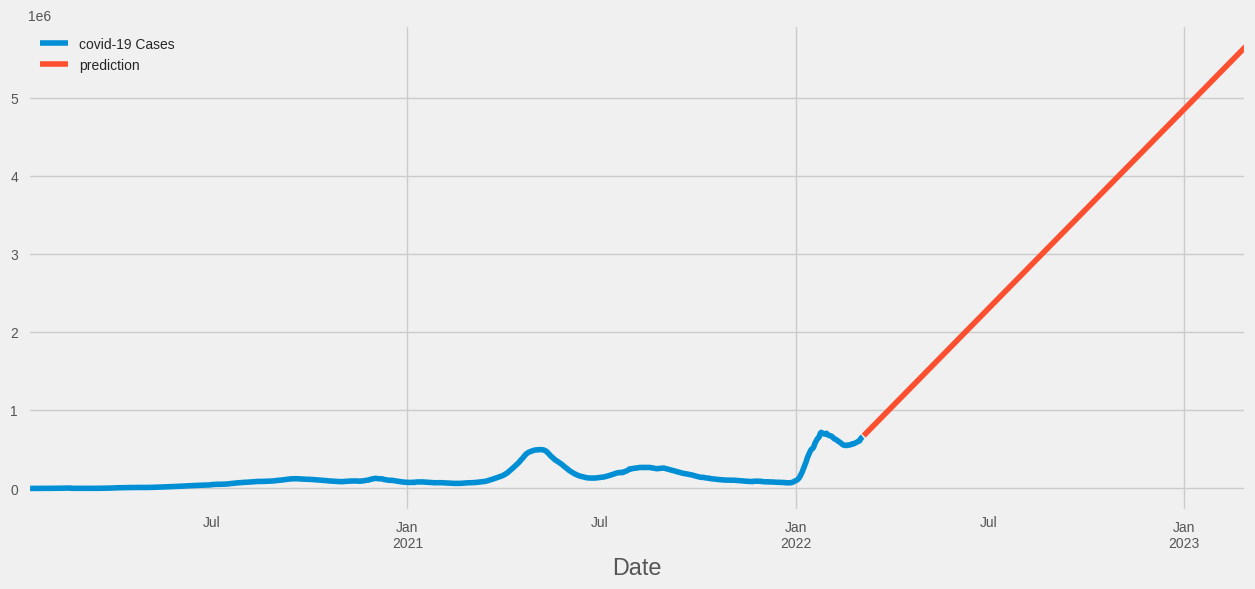

In [371]:
data2['7 days MA new cases'].plot(legend=True, label='covid-19 Cases', figsize=(14,6))
pred.plot(legend=True, label='prediction')

In [372]:
#Random Forest Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score,r2_score

In [373]:
date_train_asia

,7 days MA new cases
Date,
2020-01-10,0.000000
2020-01-11,0.000000
2020-01-12,0.000000
2020-01-13,0.000000
2020-01-14,0.000000
...,...
2021-12-28,74697.000000
2021-12-29,78371.857143
2021-12-30,84878.857143


In [374]:
#prediction  on the training dataset
import sklearn
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100,random_state=42)

#date_train_asia['Date'] = pd.to_datetime(date_train_asia['Date'])


X_train = date_train_asia
y_train = date_train_asia['7 days MA new cases']
X_test = date_test_asia
y_test = date_test_asia['7 days MA new cases']

#fit the  Train model
fit_model = model.fit(X_train, y_train)
#y_train_pred_asia = fit_model.predict(date_train_asia)

In [375]:
#prediction  on the training dataset
y_train_pred_asia = fit_model.predict(X_train)

In [376]:
print('The r_sq is: %.2f'% r2_score(y_train, y_train_pred_asia))
print('The MAE is: %.2f' % mean_absolute_error(y_train,y_train_pred_asia))
print('The MSE is: %.2f' % mean_squared_error(y_train,y_train_pred_asia))
print('The RMSE  is: %.2f' % np.sqrt(mean_squared_error(y_train,y_train_pred_asia)))
print('The EVS  is: %.2f' % np.sqrt(explained_variance_score(y_train,y_train_pred_asia)))

The r_sq is: 1.00
The MAE is: 88.68
The MSE is: 38598.57
The RMSE  is: 196.47
The EVS  is: 1.00


In [377]:
#prediction on testing set

y_test_pred_asia = fit_model.predict(X_test)

In [378]:
print('The r_sq is: %.2f'% r2_score(y_test, y_test_pred_asia))
print('The MAE is: %.2f'% mean_absolute_error(y_test, y_test_pred_asia))
print('The MSE is: %.2f'% mean_squared_error(y_test, y_test_pred_asia))
print('The RMSE is: %.2f'% np.sqrt(mean_squared_error(y_test, y_test_pred_asia)))
print('The EVS is: %.2f'% explained_variance_score(y_test, y_test_pred_asia))

The r_sq is: 0.49
The MAE is: 91928.74
The MSE is: 13332226451.79
The RMSE is: 115465.26
The EVS is: 0.81


In [379]:
print("Trainig Score:", fit_model.score(X_train, y_train))
print("Testing Score:", fit_model.score(X_test , y_test))

Trainig Score: 0.9999965183519562
Testing Score: 0.49359334600592186


In [380]:
print("Accuracy =", r2_score(y_test, y_test_pred_asia))

Accuracy = 0.49359334600592186


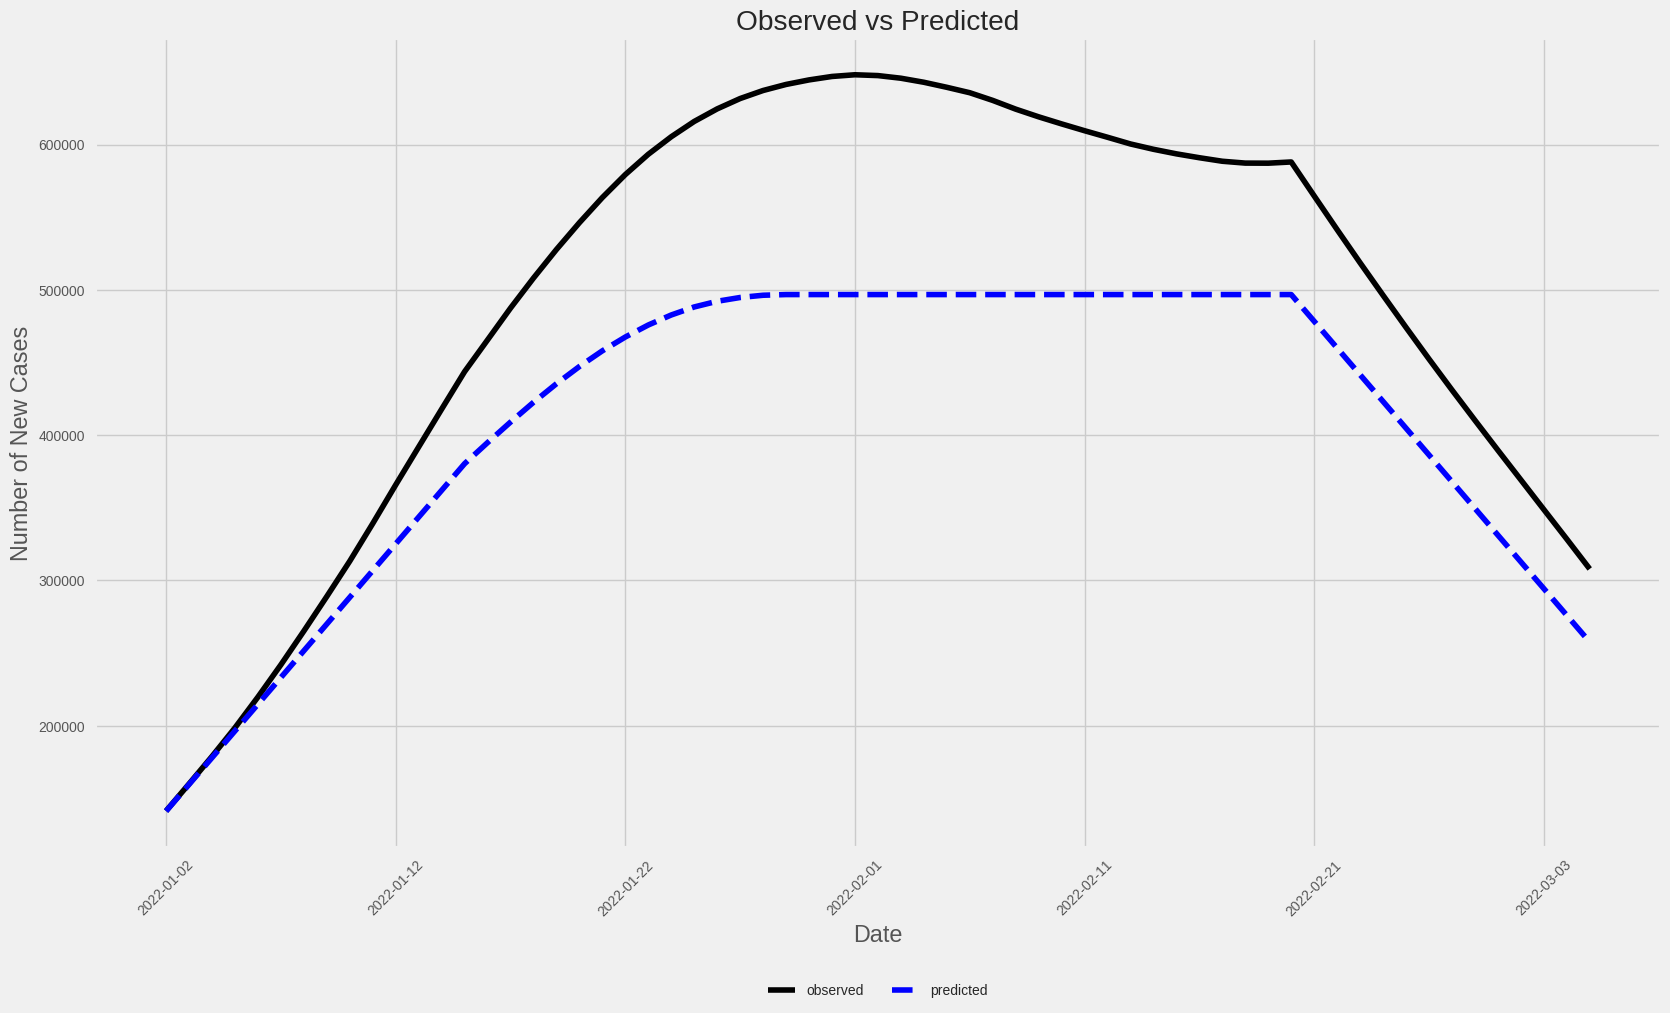

In [381]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,10]
x_ax=range(len(X_test))

#plot
window_size = 27

y_test_asia_avg_smoothed = np.convolve(y_test, np.ones(window_size)/window_size, mode='same')

y_test_pred_asia_avg_smoothed = np.convolve(y_test_pred_asia, np.ones(window_size)/window_size, mode='same')

x_labels = [d.strftime('%Y-%m-%d') for i, d in enumerate(data2_asia.index[-len(X_test)::10])] 
plt.xticks(x_ax[::10], x_labels, rotation=45)
#x_ax=x_ax[:int(len(x_ax)-1)]
# Plot smoothed data
plt.plot(x_ax, y_test_asia_avg_smoothed, label='observed', color='black', linestyle='-')
plt.plot(x_ax, y_test_pred_asia_avg_smoothed, label='predicted', color='blue', linestyle='--')
plt.ylabel('Number of New Cases')
plt.xlabel('Date')
plt.title('Observed vs Predicted')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=2, frameon=False)

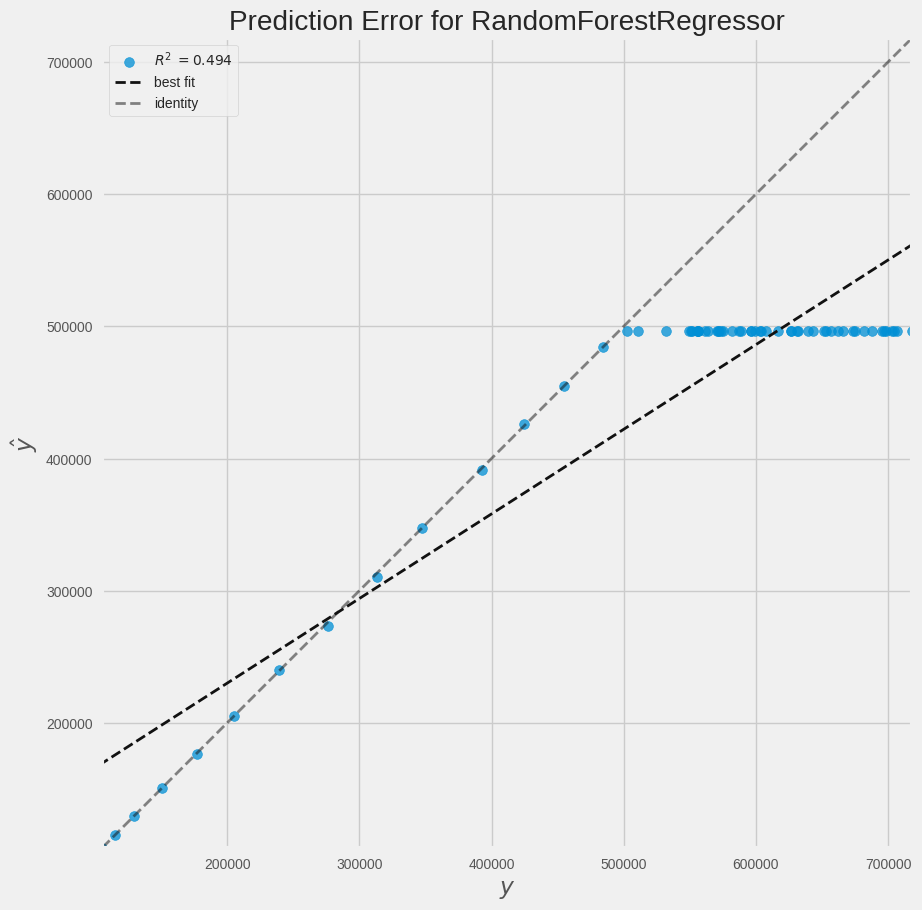

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [382]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(fit_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.poof()

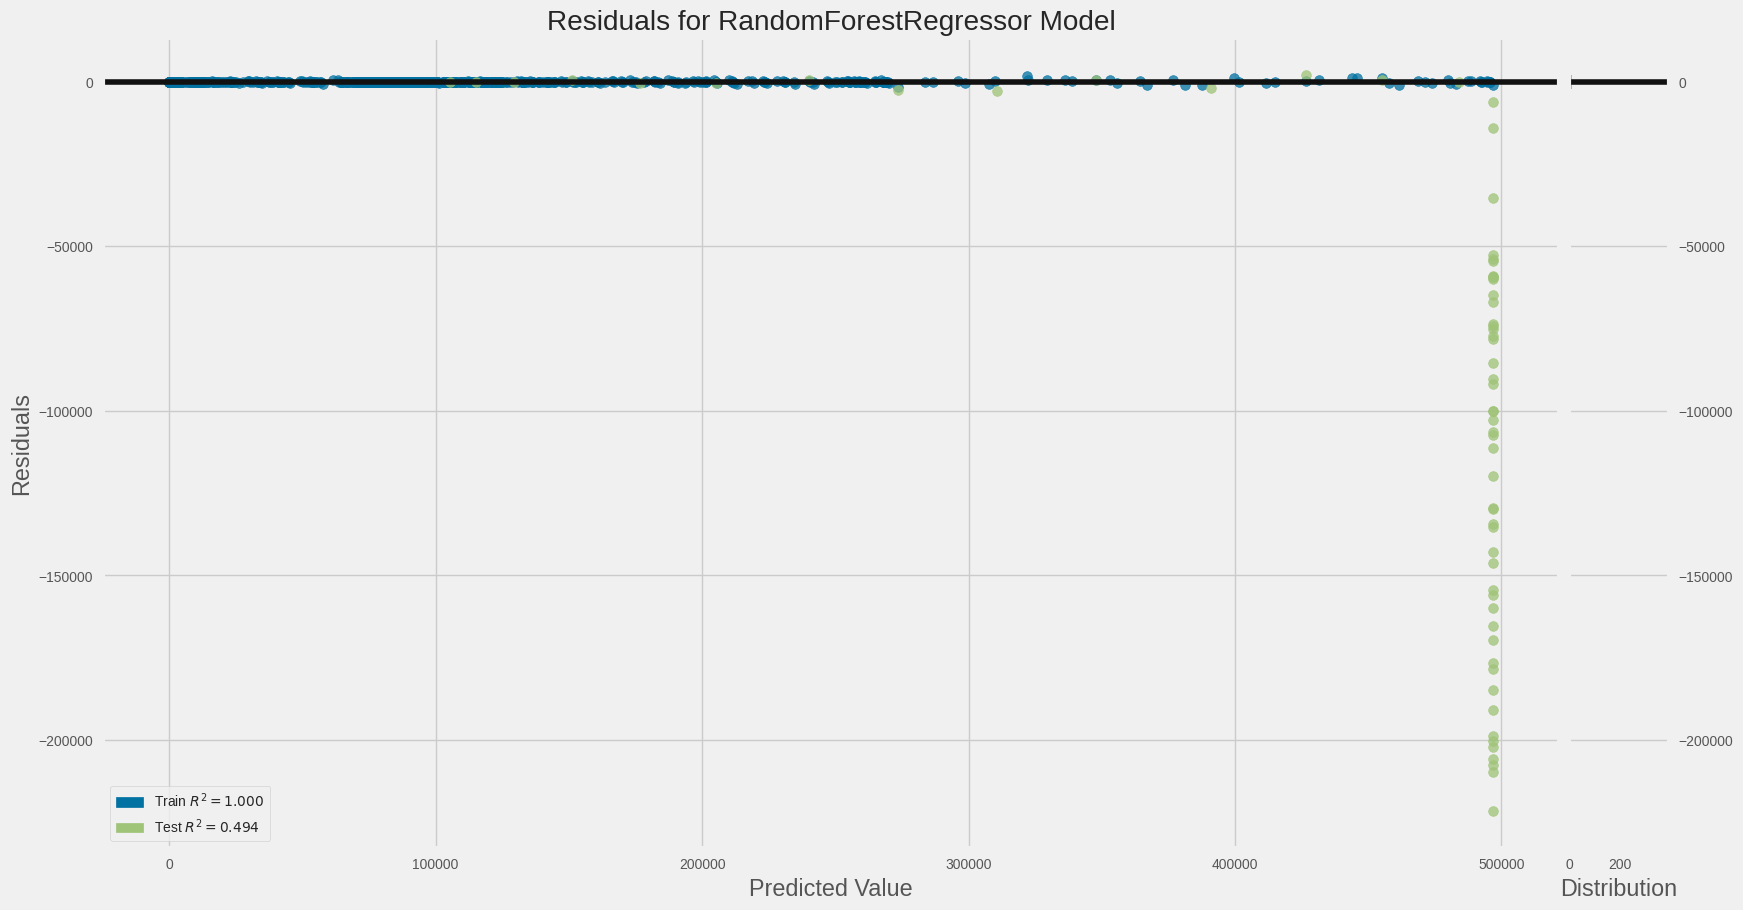

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [383]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(fit_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test,y_test)
visualizer.poof()

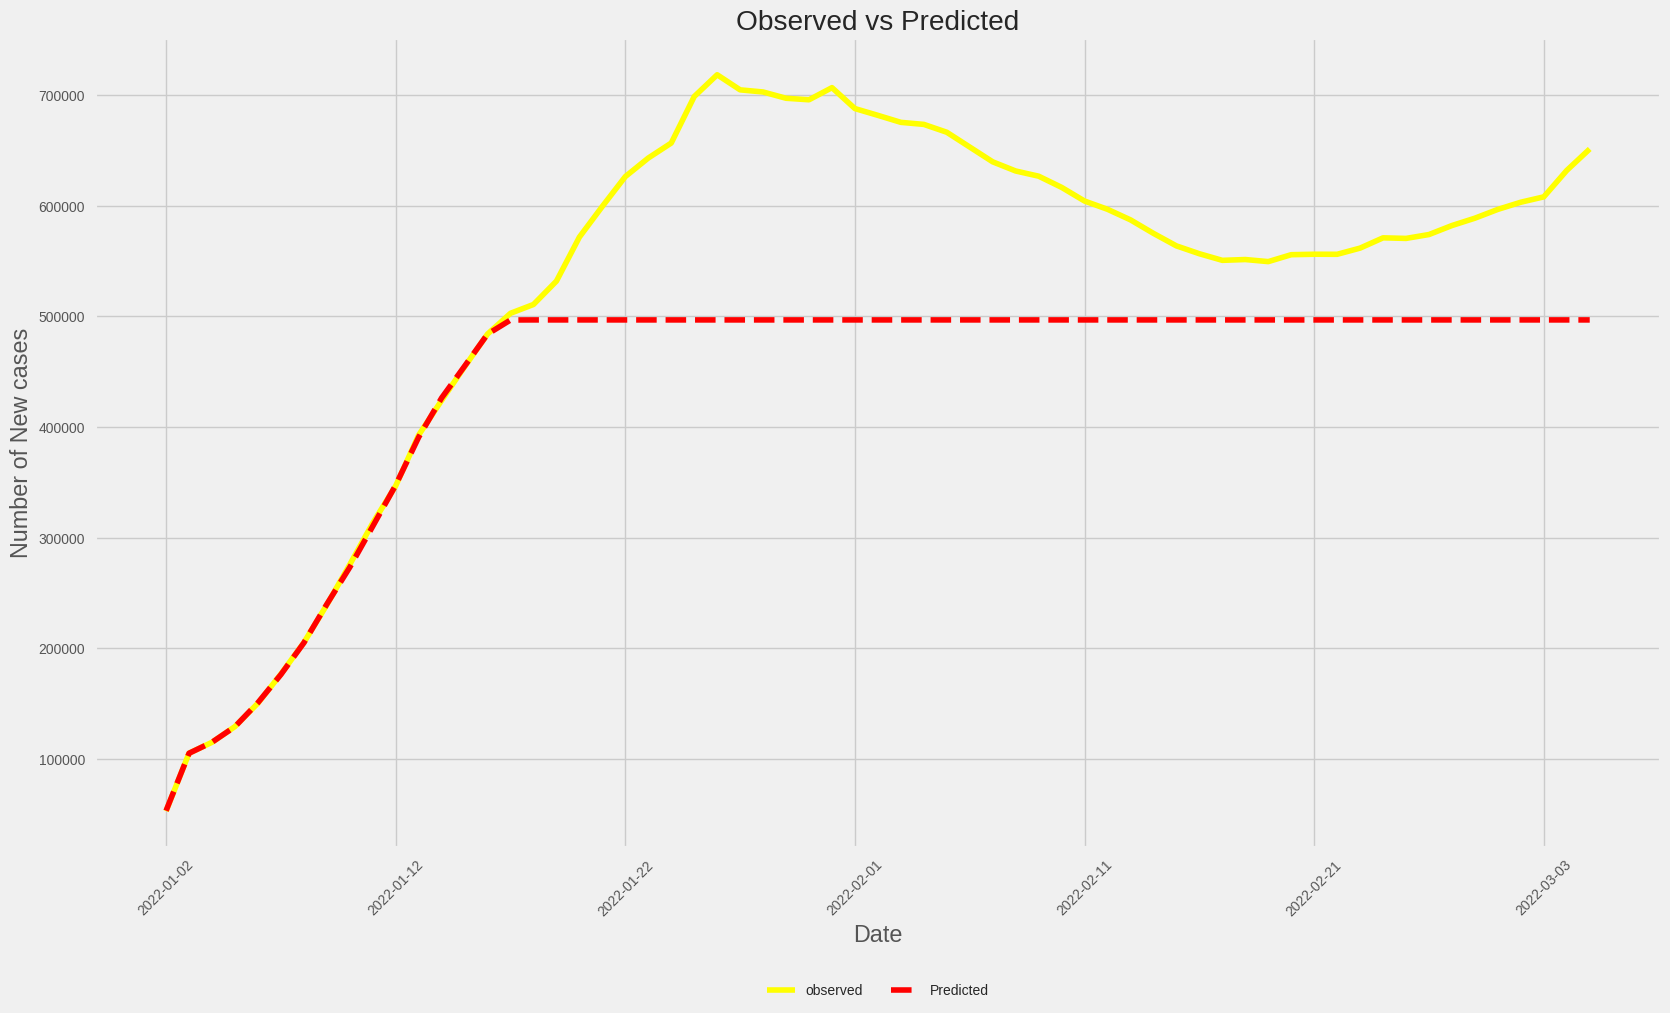

In [384]:
from statsmodels.tsa.api import ExponentialSmoothing
plt.rcParams['figure.figsize'] = [18,10]

# set x-axis labels as dates with 6-month interval
x_labels = [d.strftime('%Y-%m-%d') for i, d in enumerate(data2_asia.index[-len(X_test)::10])]
plt.xticks(x_ax[::10], x_labels, rotation=45) 

# create exponential smoothing object
model = ExponentialSmoothing(y_test, trend=None, seasonal=None, initialization_method="estimated")

# fit the model to the data
model_fit = model.fit()

# get smoothed data
y_test_CAN_smoothed = model_fit.fittedvalues

# create exponential smoothing object for predicted data
model_pred = ExponentialSmoothing(y_test_pred_asia, trend=None, seasonal=None, initialization_method="estimated")

# fit the model to the predicted data
model_fit_pred = model_pred.fit()

# get smoothed predicted data
y_test_pred_Canada_smoothed = model_fit_pred.fittedvalues

# plot smoothed data
plt.plot(x_ax, y_test_CAN_smoothed, label='observed', color='yellow', linestyle='-')
plt.plot(x_ax, y_test_pred_Canada_smoothed, label='Predicted', color='red', linestyle='--')
plt.ylabel('Number of New cases')
plt.xlabel('Date')
plt.title("Observed vs Predicted")
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=2, frameon=False)

In [385]:
date_train_asia

,7 days MA new cases
Date,
2020-01-10,0.000000
2020-01-11,0.000000
2020-01-12,0.000000
2020-01-13,0.000000
2020-01-14,0.000000
...,...
2021-12-28,74697.000000
2021-12-29,78371.857143
2021-12-30,84878.857143


In [386]:
#FB prophet Model

data2_asia_prophet=data2.groupby('Date').sum('New_Cases').reset_index() \
  .rename(columns={'Date':'ds',
                   '7 days MA new cases':'y'})

In [387]:
data2_asia_prophet

,ds,y
0,2020-01-10,0.000000
1,2020-01-11,0.000000
2,2020-01-12,0.000000
3,2020-01-13,0.000000
4,2020-01-14,0.000000
...,...,...
781,2022-03-01,603139.285714
782,2022-03-02,607969.000000
783,2022-03-03,631943.142857
784,2022-03-04,651311.571429


In [388]:
%%time
model = Prophet()
model.fit(data2_asia_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ef3brnu/xjpxyh_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ef3brnu/30tdddy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38580', 'data', 'file=/tmp/tmp1ef3brnu/xjpxyh_d.json', 'init=/tmp/tmp1ef3brnu/30tdddy5.json', 'output', 'file=/tmp/tmp1ef3brnu/prophet_modeln5dji_il/prophet_model-20230330091613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 162 ms, sys: 33.4 ms, total: 195 ms
Wall time: 514 ms


In [389]:
#Create the model using Prophet 0.95 confidence
ML_Model = Prophet(interval_width=0.95)
#Fit the Model
ML_Model.fit(data2_asia_prophet)
#Create prediction Data
Cases_Prediction = ML_Model.make_future_dataframe(periods=360)
Cases_Prediction.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ef3brnu/frar1b1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ef3brnu/0y31t6ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41135', 'data', 'file=/tmp/tmp1ef3brnu/frar1b1q.json', 'init=/tmp/tmp1ef3brnu/0y31t6ls.json', 'output', 'file=/tmp/tmp1ef3brnu/prophet_modelvby798ta/prophet_model-20230330091613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
1141,2023-02-24
1142,2023-02-25
1143,2023-02-26
1144,2023-02-27
1145,2023-02-28


In [390]:
#predicting the future with date, and upper and lower limit of y value
Cases_Forecast = ML_Model.predict(Cases_Prediction)
Cases_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1141,2023-02-24,1.620567e+06,1.021598e+06,2.274089e+06
1142,2023-02-25,1.624582e+06,1.047210e+06,2.243772e+06
1143,2023-02-26,1.627908e+06,1.019685e+06,2.294189e+06
1144,2023-02-27,1.631978e+06,1.046656e+06,2.280230e+06
1145,2023-02-28,1.636256e+06,1.061272e+06,2.285726e+06


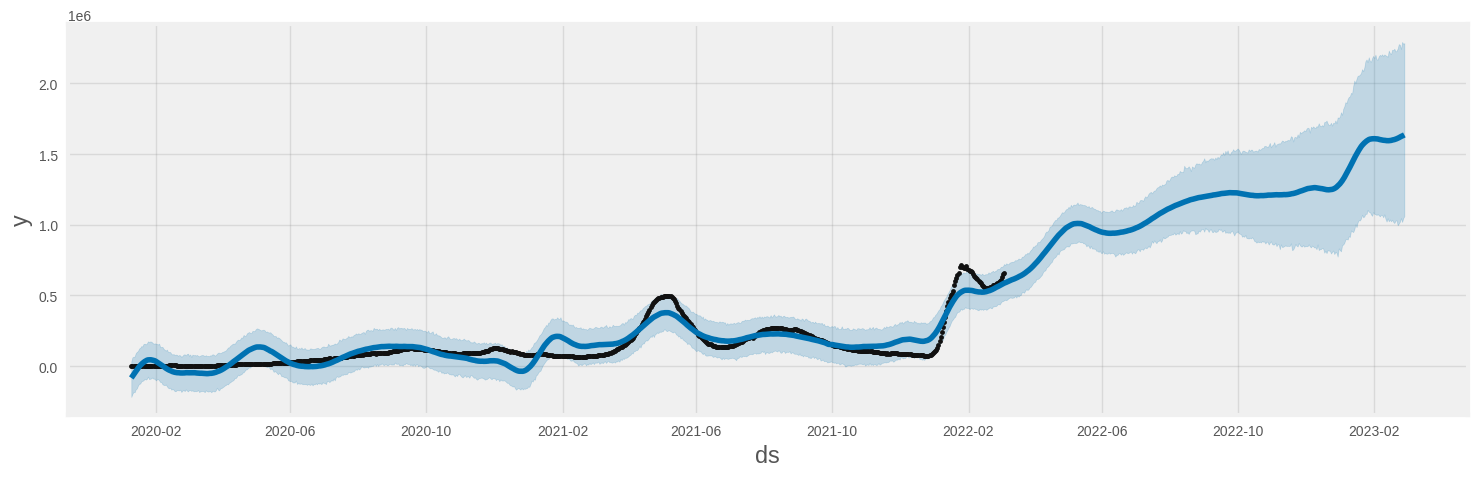

In [391]:
Cases_forecasting = ML_Model.plot(Cases_Forecast, figsize=(15,5))

In [392]:
#Evaluation Metrics of model
from statsmodels.tools.eval_measures import rmse

In [393]:
predictions = data2_asia_prophet.iloc[-7:]

In [394]:
predictions

,ds,y
779,2022-02-27,588716.285714
780,2022-02-28,596672.714286
781,2022-03-01,603139.285714
782,2022-03-02,607969.000000
783,2022-03-03,631943.142857
784,2022-03-04,651311.571429
785,2022-03-05,662127.428571


In [395]:
data2_asia_prophet['y']

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
           ...      
781    603139.285714
782    607969.000000
783    631943.142857
784    651311.571429
785    662127.428571
Name: y, Length: 786, dtype: float64

In [396]:
#Check for seasonality
#fig = data2_asia_prophet.plot_components(Cases_Forecast);

In [397]:
#Check for trend changes in data
#Highlights major points of change
#from prophet.plot import add_changepoints_to_plot
#fig = plot(Cases_Forecast)
#a = add_changepoints_to_plot(fig.gca(),m,Cases_Forecast)
#plt.title('Major Trend/Point Change in Forecast of COVID19')
#plt.savefig('MajorTrendChanges.png')

In [398]:
date_train_asia

,7 days MA new cases
Date,
2020-01-10,0.000000
2020-01-11,0.000000
2020-01-12,0.000000
2020-01-13,0.000000
2020-01-14,0.000000
...,...
2021-12-28,74697.000000
2021-12-29,78371.857143
2021-12-30,84878.857143


In [399]:
#Arima model

In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

In [402]:
#Training the ARIMA model
!pip install pmdarima
from pmdarima.arima import auto_arima, ADFTest
model_arima = auto_arima(data2['7 days MA new cases'], trace = True, error_action='ignore', start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                   suppress_warnings = True, stepwise = False, seasonal = False)
model_arima.fit(date_train_asia['7 days MA new cases'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15987.065, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15420.772, Time=1.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15463.833, Time=1.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15354.131, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14876.542, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14808.035, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14801.332, Time=1.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14767.044, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14840.089, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14806.212, Time=1.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14791.935, Time=1.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14755.305, Time=3.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14786.654, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] interc

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [403]:
from statsmodels.tsa.arima_model import ARIMA

In [404]:
model=sm.tsa.arima.ARIMA(date_train_asia['7 days MA new cases'],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     7 days MA new cases   No. Observations:                  723
Model:                  ARIMA(1, 0, 5)   Log Likelihood               -6637.863
Date:                 Thu, 30 Mar 2023   AIC                          13291.727
Time:                         09:17:39   BIC                          13328.394
Sample:                     01-10-2020   HQIC                         13305.880
                          - 01-01-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.161e+05   1.14e-09   1.02e+14      0.000    1.16e+05    1.16e+05
ar.L1          0.9974      0.004    248.763      0.000       0.990       1.005
ma.L1          0.1601      0.068      2.357      0.018       0.027       0.293
ma.L2          0.5979      0.056     10.605      0.000       0.487       0.708
ma.L3          0.4523      0.081      5.563      0.000       0.293       0.612
ma.L4          0.3790      0.065      5.805      0.000       0.251       0.507
ma.L5          0.7579      0.081      9.304      0.000       0.598       0.918
sigma2      1.129e+07   1.39e-09   8.12e+15      0.000    1.13e+07    1.13e+07
===================================================================================
Ljung-Box (L1) (Q):                 125.67   Jarque-Bera (JB):               631.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.60   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.84e+31. Standard errors may be unstable.
"""

In [405]:
start = len(date_train_asia)
end = len(date_train_asia)+len(date_test_asia)-1
predict = model.predict(start =start , end =end,type='levels')
print(predict)
#predict.index=data2.index[start:end+1]


2022-01-02    103962.758785
2022-01-03    108932.541341
2022-01-04    113199.487354
2022-01-05    116207.837573
2022-01-06    117909.585936
                  ...      
2022-03-01    117677.008126
2022-03-02    117672.996943
2022-03-03    117668.996008
2022-03-04    117665.005298
2022-03-05    117661.024784
Freq: D, Name: predicted_mean, Length: 63, dtype: float64


Test RMSE: 451087.214


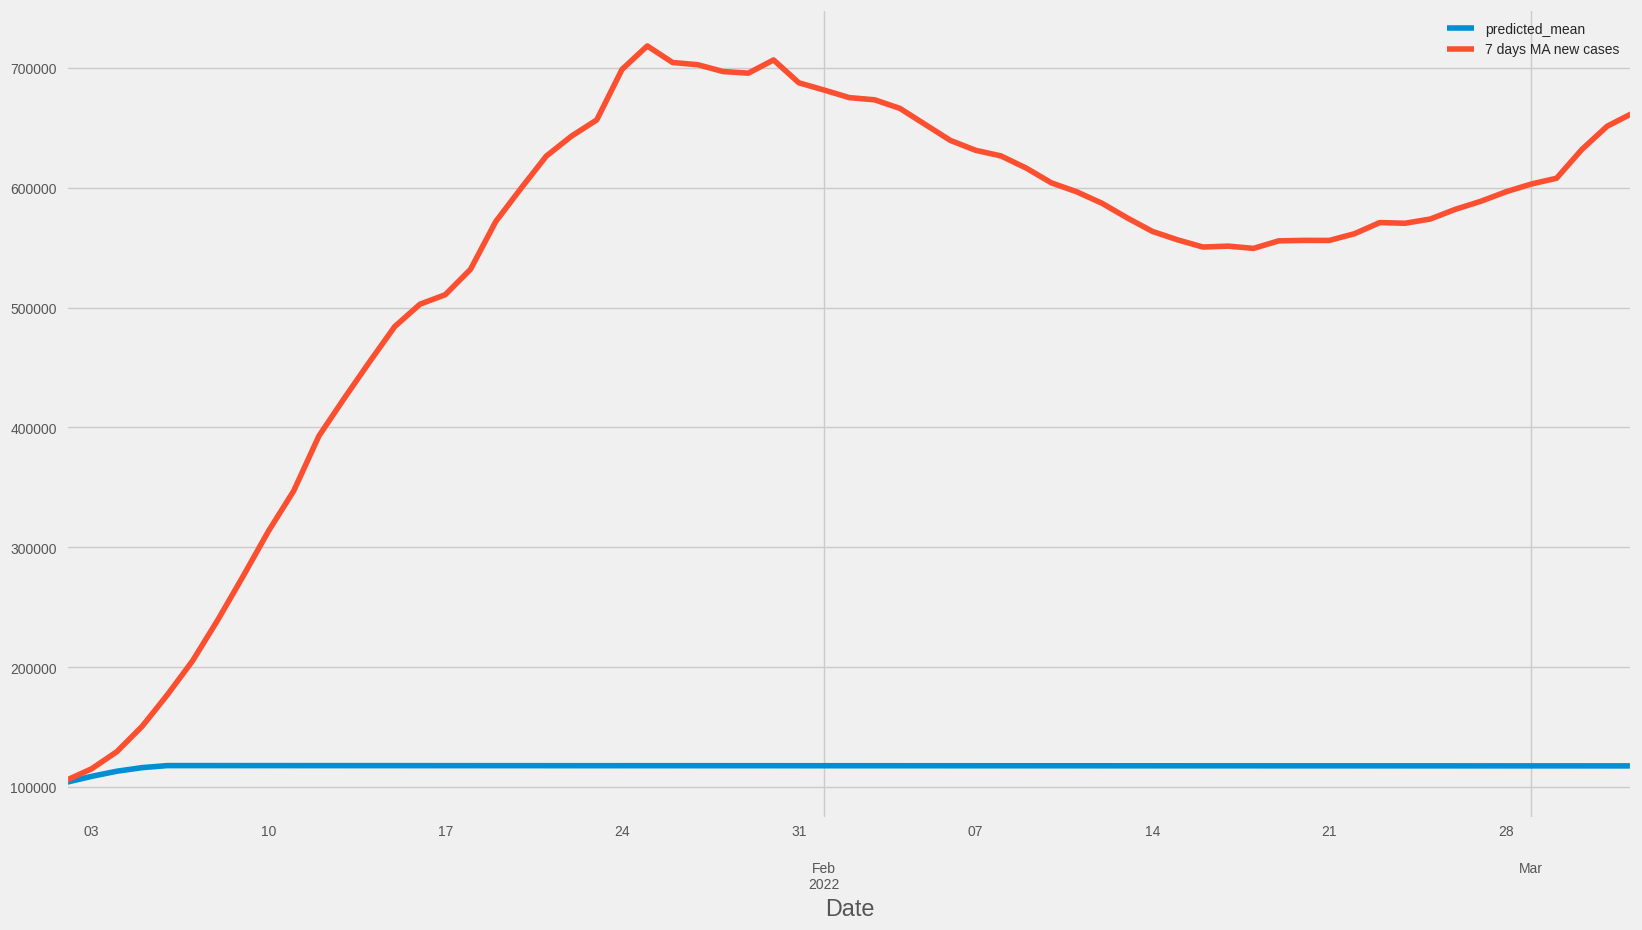

In [406]:
predict.plot(legend=True)
date_test_asia['7 days MA new cases'].plot(legend=True)

# Evaluate predictions
rmse = sqrt(mean_squared_error(predict,date_test_asia['7 days MA new cases']))
print('Test RMSE: %.3f' % rmse)

In [407]:
model2=sm.tsa.arima.ARIMA(data2['7 days MA new cases'],order=(1,0,5))
model2=model2.fit()
data2.tail()

,7 days MA new cases
Date,
2022-03-01,603139.285714
2022-03-02,607969.000000
2022-03-03,631943.142857
2022-03-04,651311.571429
2022-03-05,662127.428571


In [408]:
index_future_dates=pd.date_range(start='2022-03-05',end='2023-03-04')
pred=model2.predict(start=len(data2),end=len(data2)+364,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

2022-03-05    680741.776379
2022-03-06    688934.708728
2022-03-07    701658.647569
2022-03-08    708521.212784
2022-03-09    706864.645996
                  ...      
2023-02-28    534578.024724
2023-03-01    534178.337030
2023-03-02    533779.064701
2023-03-03    533380.207306
2023-03-04    532981.764414
Freq: D, Name: ARIMA Predictions, Length: 365, dtype: float64


<Axes: >

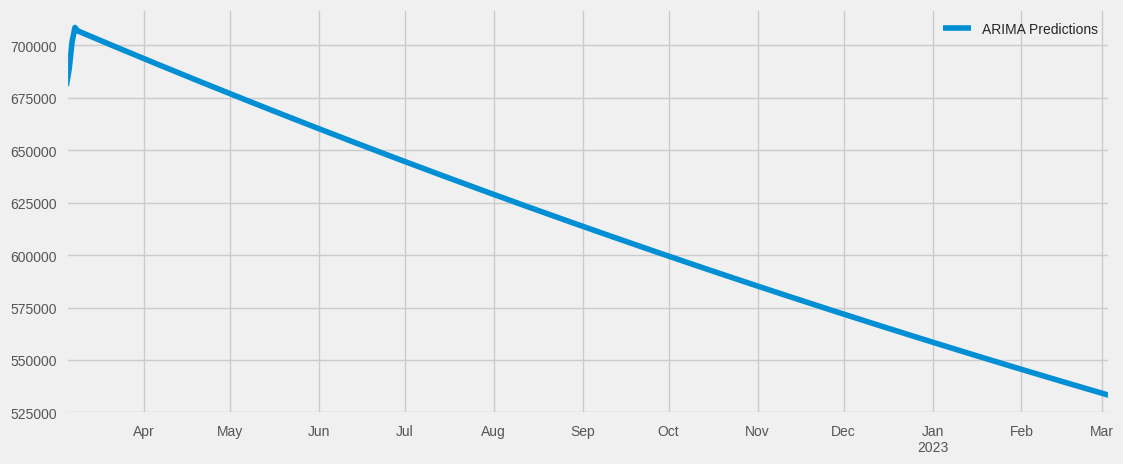

In [409]:
pred.plot(figsize=(12,5),legend=True)

In [410]:
data2

,7 days MA new cases
Date,
2020-01-10,0.000000
2020-01-11,0.000000
2020-01-12,0.000000
2020-01-13,0.000000
2020-01-14,0.000000
...,...
2022-03-01,603139.285714
2022-03-02,607969.000000
2022-03-03,631943.142857


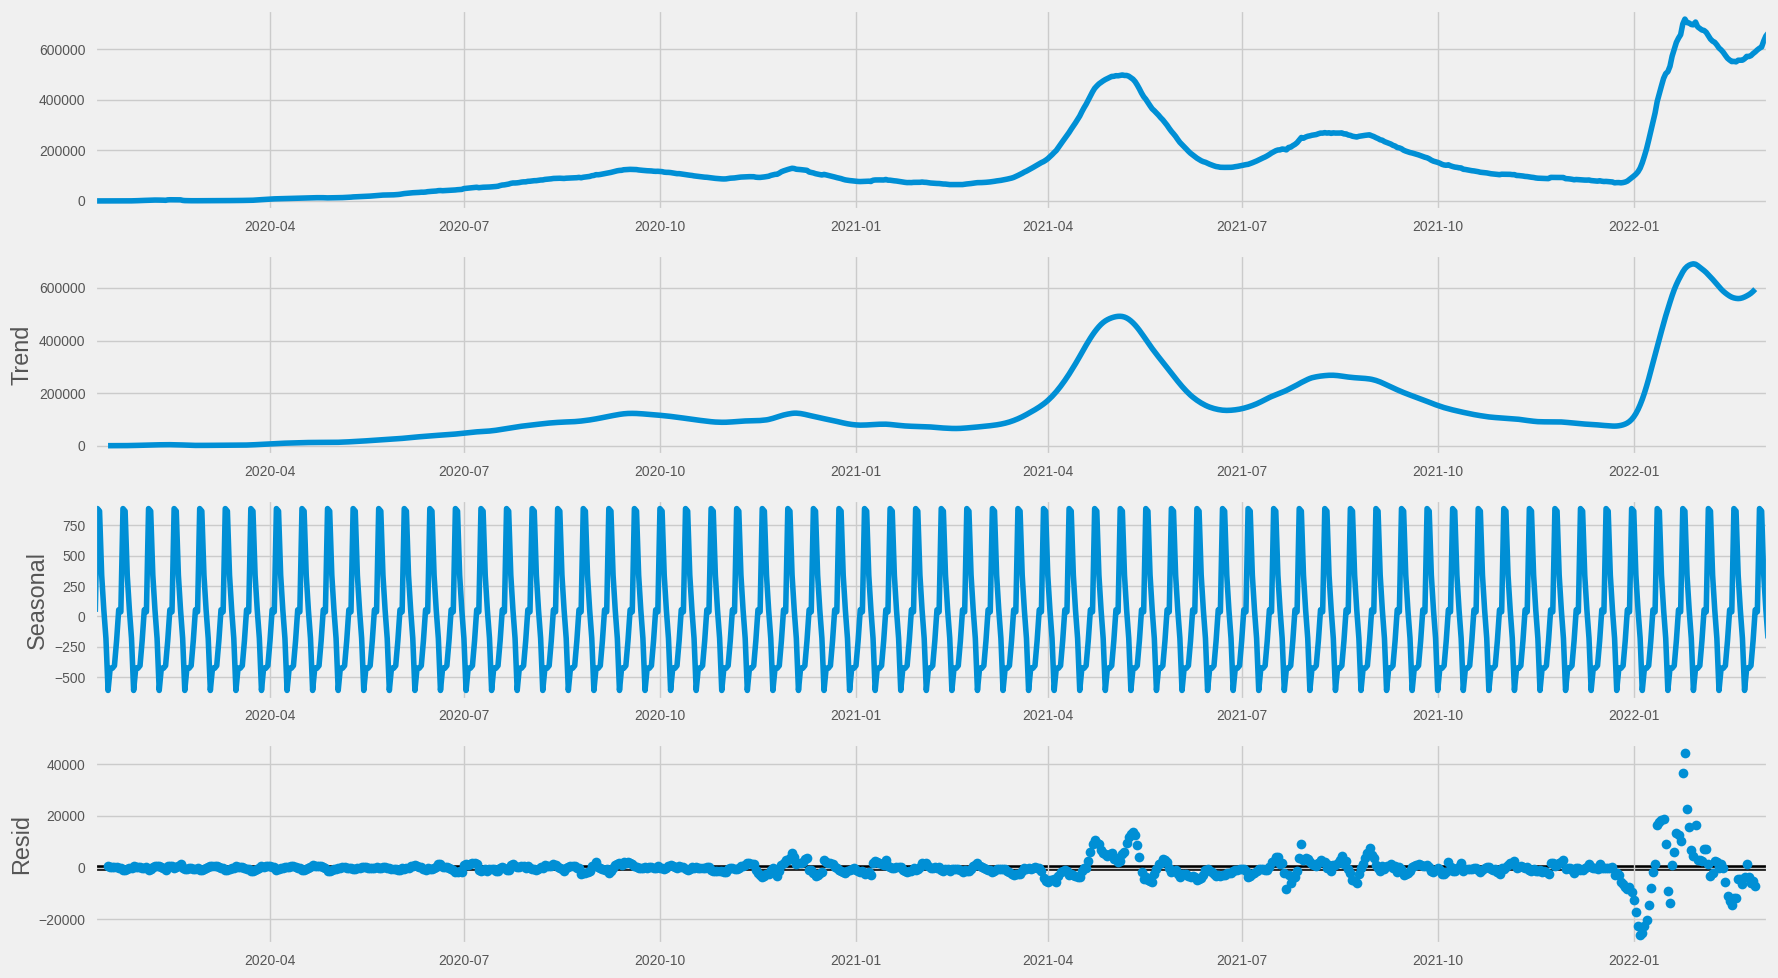

In [411]:
decomposition = sm.tsa.seasonal_decompose(data2,period =12)
fig = decomposition.plot()

In [412]:
# perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test')

dftest = adfuller(data2, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p value','#Lags used', 'No:of observations found'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic                0.968420
p value                       0.993921
#Lags used                   21.000000
No:of observations found    764.000000
Critical Value (1%)          -3.438938
Critical Value (5%)          -2.865330
Critical Value (10%)         -2.568788
dtype: float64
